In [12]:
import os
from pathlib import Path
from path_utils import use_path

base_dir = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()

# Use relative paths from the base directory
config_path = str(base_dir / "configs/datasets/nuplan/8cams_undistorted.yaml")
checkpoint_path = str(base_dir / "output/master-project/run_omnire_undistorted_8cams_0")

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pyquaternion import Quaternion

# Function to get ego vehicle position from the ego pose matrix
def get_ego_position_info(ego_pose_matrix):
    # Extract position from the translation part of the matrix (last column)
    position = ego_pose_matrix[:3, 3]
    
    # Extract rotation as quaternion
    rotation_matrix = ego_pose_matrix[:3, :3]
    # Create quaternion from rotation matrix
    quat = Quaternion(matrix=rotation_matrix)
    # Extract yaw (heading) from quaternion as Euler angle
    yaw = quat.yaw_pitch_roll[0]
    
    return {
        "position": position,
        "x": position[0],
        "y": position[1],
        "z": position[2],
        "quaternion": quat,
        "heading": yaw,
        "heading_degrees": np.degrees(yaw)
    }

# Specify the scene directory and first frame index
def print_ego_starting_position(scene_dir, frame_idx=0):
    # Load the ego pose matrix for the first frame
    ego_pose_path = os.path.join(scene_dir, "ego_pose", f"{frame_idx:03d}.txt")
    
    if not os.path.exists(ego_pose_path):
        print(f"Error: Ego pose file not found at {ego_pose_path}")
        return None
    
    try:
        # Load the 4x4 transformation matrix
        ego_pose_matrix = np.loadtxt(ego_pose_path)
        
        # Get position and orientation information
        ego_info = get_ego_position_info(ego_pose_matrix)
        
        # Print the starting position information
        print("=== Ego Vehicle Starting Position (Frame 0) ===")
        print(f"Position (x, y, z): ({ego_info['x']:.3f}, {ego_info['y']:.3f}, {ego_info['z']:.3f})")
        print(f"Heading: {ego_info['heading']:.3f} rad, {ego_info['heading_degrees']:.2f}°")
        print(f"Quaternion (w, x, y, z): ({ego_info['quaternion'].w:.3f}, {ego_info['quaternion'].x:.3f}, {ego_info['quaternion'].y:.3f}, {ego_info['quaternion'].z:.3f})")
        print("Full transformation matrix:")
        print(ego_pose_matrix)
        
        # Return the information for further use if needed
        return ego_info
    except Exception as e:
        print(f"Error reading ego pose file: {e}")
        return None

In [14]:
# List available scenes in the NuPlan dataset
import glob

# Path to the NuPlan processed data directory
nuplan_data_dir = os.path.join(base_dir, "drivestudio/data/nuplan/processed/mini")

# Check if the directory exists
if os.path.exists(nuplan_data_dir):
    # List all scene directories
    scene_dirs = glob.glob(os.path.join(nuplan_data_dir, "*"))
    scene_dirs = [d for d in scene_dirs if os.path.isdir(d)]
    
    print(f"Found {len(scene_dirs)} scenes in NuPlan dataset:")
    for i, scene_dir in enumerate(scene_dirs):
        print(f"{i+1}. {os.path.basename(scene_dir)}")
else:
    print(f"NuPlan data directory not found at {nuplan_data_dir}")
    print("Please update the path to point to your NuPlan processed data location.")

Found 6 scenes in NuPlan dataset:
1. 2021.05.12.22.00.38_veh-35_01008_01518
2. 2021.05.12.22.28.35_veh-35_00620_01164
3. 2021.05.12.23.36.44_veh-35_02035_02387
4. 2021.05.12.23.36.44_veh-35_01133_01535
5. 2021.05.25.14.16.10_veh-35_01690_02183
6. 2021.05.12.23.36.44_veh-35_00152_00504


Analyzing scene: 2021.05.12.22.00.38_veh-35_01008_01518

=== Ego Vehicle Starting Position (Frame 0) ===
Position (x, y, z): (664647.261, 3999250.843, 606.740)
Heading: -2.066 rad, -118.35°
Quaternion (w, x, y, z): (-0.512, 0.001, 0.012, 0.859)
Full transformation matrix:
[[-4.74875320e-01  8.79989872e-01 -1.05477810e-02  6.64647261e+05]
 [-8.79924247e-01 -4.74566619e-01  2.28000857e-02  3.99925084e+06]
 [ 1.50582198e-02  2.01084462e-02  9.99684400e-01  6.06740224e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


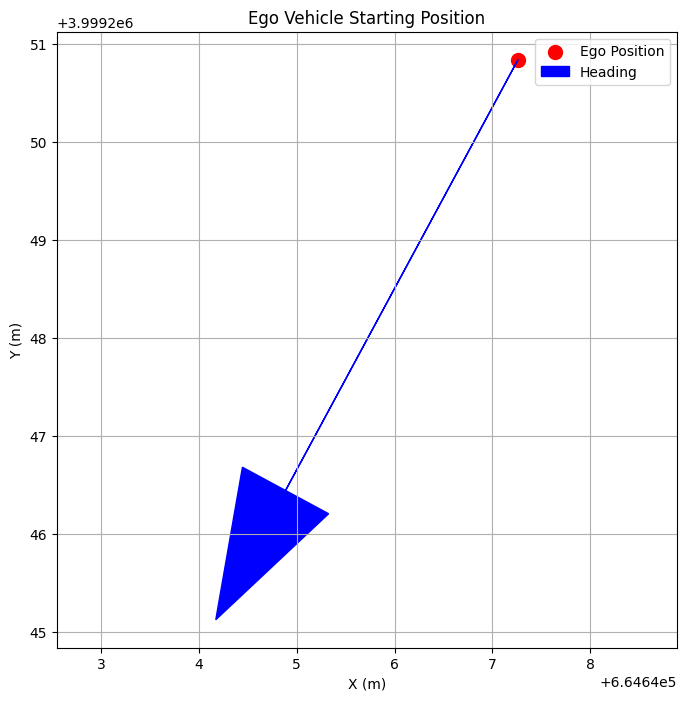

In [15]:
# Analyze the ego position of the first scene (or specify a different scene index)
scene_index = 0  # Change this to analyze a different scene

if os.path.exists(nuplan_data_dir) and len(scene_dirs) > scene_index:
    selected_scene = scene_dirs[scene_index]
    print(f"Analyzing scene: {os.path.basename(selected_scene)}\n")
    
    # Print ego starting position for the selected scene
    ego_info = print_ego_starting_position(selected_scene)
    
    # Optionally, visualize the ego position in a 2D plot
    if ego_info:
        plt.figure(figsize=(8, 8))
        plt.scatter(ego_info['x'], ego_info['y'], color='red', s=100, marker='o', label='Ego Position')
        
        # Draw an arrow indicating the heading direction
        arrow_length = 5.0  # adjust as needed
        dx = arrow_length * np.cos(ego_info['heading'])
        dy = arrow_length * np.sin(ego_info['heading'])
        plt.arrow(ego_info['x'], ego_info['y'], dx, dy, head_width=1.0, head_length=1.5, fc='blue', ec='blue', label='Heading')
        
        plt.axis('equal')
        plt.grid(True)
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('Ego Vehicle Starting Position')
        plt.legend()
        plt.show()
else:
    print("Cannot analyze ego position: No valid scene found.")


Calculating ego movement in scene: 2021.05.12.22.00.38_veh-35_01008_01518

=== Ego Vehicle Movement ===
From frame 0 to 50:
Start position: (664647.261, 3999250.843, 606.740)
End position: (664627.840, 3999214.200, 607.244)
Delta position (x, y, z): (-19.421, -36.643, 0.504)
Distance traveled: 41.472 m
Delta heading: 0.006 rad, 0.32°


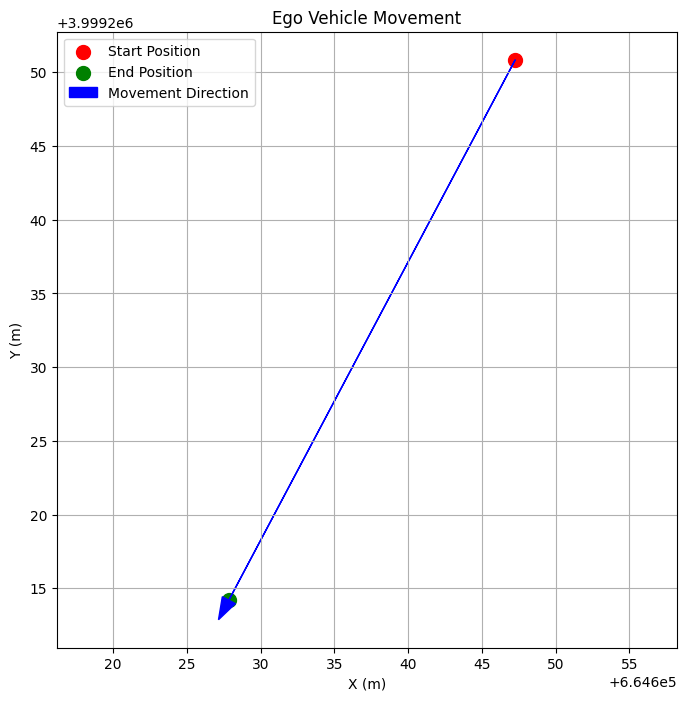

In [16]:
def calculate_ego_movement(scene_dir, start_frame=0, end_frame=50):
    """
    Calculate and visualize the movement of ego vehicle between two frames.
    
    Args:
        scene_dir: Directory containing the scene data
        start_frame: Index of the starting frame (default: 0)
        end_frame: Index of the ending frame (default: 1)
    
    Returns:
        A dictionary containing the movement information
    """
    # Load the ego pose matrices for both frames
    start_pose_path = os.path.join(scene_dir, "ego_pose", f"{start_frame:03d}.txt")
    end_pose_path = os.path.join(scene_dir, "ego_pose", f"{end_frame:03d}.txt")
    
    if not os.path.exists(start_pose_path) or not os.path.exists(end_pose_path):
        print(f"Error: Ego pose files not found")
        return None
    
    try:
        # Load the transformation matrices
        start_pose_matrix = np.loadtxt(start_pose_path)
        end_pose_matrix = np.loadtxt(end_pose_path)
        
        # Get position and orientation information
        start_info = get_ego_position_info(start_pose_matrix)
        end_info = get_ego_position_info(end_pose_matrix)
        
        # Calculate deltas
        delta_x = end_info['x'] - start_info['x']
        delta_y = end_info['y'] - start_info['y']
        delta_z = end_info['z'] - start_info['z']
        delta_heading = end_info['heading'] - start_info['heading']
        # Normalize heading delta to be within [-π, π]
        delta_heading = (delta_heading + np.pi) % (2 * np.pi) - np.pi
        
        # Calculate elapsed time if timestamps are available
        # This would require accessing the timestamp information from the data
        
        # Calculate distance traveled
        distance = np.sqrt(delta_x**2 + delta_y**2)
        
        movement_info = {
            'start_frame': start_frame,
            'end_frame': end_frame,
            'start_position': (start_info['x'], start_info['y'], start_info['z']),
            'end_position': (end_info['x'], end_info['y'], end_info['z']),
            'delta_position': (delta_x, delta_y, delta_z),
            'delta_heading': delta_heading,
            'distance': distance,
            'start_info': start_info,
            'end_info': end_info
        }
        
        # Print the movement information
        print("=== Ego Vehicle Movement ===")
        print(f"From frame {start_frame} to {end_frame}:")
        print(f"Start position: ({start_info['x']:.3f}, {start_info['y']:.3f}, {start_info['z']:.3f})")
        print(f"End position: ({end_info['x']:.3f}, {end_info['y']:.3f}, {end_info['z']:.3f})")
        print(f"Delta position (x, y, z): ({delta_x:.3f}, {delta_y:.3f}, {delta_z:.3f})")
        print(f"Distance traveled: {distance:.3f} m")
        print(f"Delta heading: {delta_heading:.3f} rad, {np.degrees(delta_heading):.2f}°")
        
        return movement_info
    
    except Exception as e:
        print(f"Error calculating ego movement: {e}")
        return None

# Example usage of the calculate_ego_movement function

if os.path.exists(nuplan_data_dir) and len(scene_dirs) > scene_index:
    selected_scene = scene_dirs[scene_index]
    print(f"\nCalculating ego movement in scene: {os.path.basename(selected_scene)}\n")
    
    # Calculate ego movement between the first two frames
    movement_info = calculate_ego_movement(selected_scene, start_frame=0, end_frame=50)
    
    # Optionally visualize the movement
    if movement_info:
        plt.figure(figsize=(8, 8))
        plt.scatter(movement_info['start_position'][0], movement_info['start_position'][1], color='red', s=100, marker='o', label='Start Position')
        plt.scatter(movement_info['end_position'][0], movement_info['end_position'][1], color='green', s=100, marker='o', label='End Position')
        
        # Draw an arrow indicating the movement direction
        plt.arrow(movement_info['start_position'][0], movement_info['start_position'][1],
                  movement_info['delta_position'][0], movement_info['delta_position'][1],
                  head_width=1.0, head_length=1.5, fc='blue', ec='blue', label='Movement Direction')
        
        plt.axis('equal')
        plt.grid(True)
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('Ego Vehicle Movement')
        plt.legend()
        plt.show()
else:
    print("Cannot calculate ego movement: No valid scene found.")

In [24]:
def calculate_agent_movement(instances_info, agent_id, start_frame=0, end_frame=1):
    """
    Calculate the movement of a specific agent/vehicle between two frames.
    
    Args:
        instances_info: Dictionary containing instance information about all objects
        agent_id: ID of the agent to track (as a string)
        start_frame: Starting frame number (default 0)
        end_frame: Ending frame number (default 1)
    
    Returns:
        Dictionary containing movement information or None if error occurs
    """
    try:
        # Initialize movement info dictionary
        movement_info = {
            'start_position': None,
            'end_position': None,
            'delta_position': None,
            'distance': None,
            'delta_heading': None
        }
        
        # Make sure the agent exists in the instances_info
        if agent_id not in instances_info:
            raise ValueError(f"Agent with ID {agent_id} not found in instances_info")
        
        # Get agent data
        agent_data = instances_info[agent_id]
        frame_annotations = agent_data['frame_annotations']
        
        # Check if both frames are available for this agent
        if start_frame not in frame_annotations['frame_idx'] or end_frame not in frame_annotations['frame_idx']:
            raise ValueError(f"Agent {agent_id} not present in both frames")
        
        # Get indices for the start and end frames
        start_idx = frame_annotations['frame_idx'].index(start_frame)
        end_idx = frame_annotations['frame_idx'].index(end_frame)
        
        # Extract transformation matrices
        start_transform = np.array(frame_annotations['obj_to_world'][start_idx]).reshape(4, 4)
        end_transform = np.array(frame_annotations['obj_to_world'][end_idx]).reshape(4, 4)
        
        # Extract positions (translation part of the transformation matrix)
        start_pos = start_transform[:3, 3]
        end_pos = end_transform[:3, 3]
        
        # Calculate deltas
        delta_x = end_pos[0] - start_pos[0]
        delta_y = end_pos[1] - start_pos[1]
        delta_z = end_pos[2] - start_pos[2]
        
        # Calculate distance traveled
        distance = np.sqrt(delta_x**2 + delta_y**2 + delta_z**2)
        
        # Calculate heading change
        # Extract rotation matrices
        start_rotation = start_transform[:3, :3]
        end_rotation = end_transform[:3, :3]
        
        # Convert to quaternions for easier heading extraction
        start_quat = Quaternion(matrix=start_rotation)
        end_quat = Quaternion(matrix=end_rotation)
        
        # Extract yaw (heading) from quaternions
        start_heading = start_quat.yaw_pitch_roll[0]
        end_heading = end_quat.yaw_pitch_roll[0]
        
        # Calculate heading change and normalize to [-pi, pi]
        delta_heading = end_heading - start_heading
        delta_heading = (delta_heading + np.pi) % (2 * np.pi) - np.pi
        
        # Populate movement info
        movement_info['start_position'] = start_pos
        movement_info['end_position'] = end_pos
        movement_info['delta_position'] = (delta_x, delta_y, delta_z)
        movement_info['distance'] = distance
        movement_info['delta_heading'] = delta_heading
        
        # Print the movement information
        print(f"=== Agent {agent_id} Movement ===")
        print(f"From frame {start_frame} to {end_frame}:")
        print(f"Start position: ({start_pos[0]:.3f}, {start_pos[1]:.3f}, {start_pos[2]:.3f})")
        print(f"End position: ({end_pos[0]:.3f}, {end_pos[1]:.3f}, {end_pos[2]:.3f})")
        print(f"Delta position (x, y, z): ({delta_x:.3f}, {delta_y:.3f}, {delta_z:.3f})")
        print(f"Distance traveled: {distance:.3f} m")
        print(f"Delta heading: {delta_heading:.3f} rad, {np.degrees(delta_heading):.2f}°")
        
        return movement_info
    
    except Exception as e:
        print(f"Error calculating agent movement: {e}")
        return None
    
if os.path.exists(nuplan_data_dir) and len(scene_dirs) > scene_index:
    agent_token = "b582d95cb714544d"
    selected_scene = scene_dirs[scene_index]
    print(f"\nCalculating agent movement in scene: {os.path.basename(selected_scene)}\n")
    
    # Calculate ego movement between the first two frames
    movement_info = calculate_agent_movement(selected_scene, agent_token, start_frame=0, end_frame=50)
    
    # Optionally visualize the movement
    if movement_info:
        plt.figure(figsize=(8, 8))
        plt.scatter(movement_info['start_position'][0], movement_info['start_position'][1], color='red', s=100, marker='o', label='Start Position')
        plt.scatter(movement_info['end_position'][0], movement_info['end_position'][1], color='green', s=100, marker='o', label='End Position')
        
        # Draw an arrow indicating the movement direction
        plt.arrow(movement_info['start_position'][0], movement_info['start_position'][1],
                  movement_info['delta_position'][0], movement_info['delta_position'][1],
                  head_width=1.0, head_length=1.5, fc='blue', ec='blue', label='Movement Direction')
        
        plt.axis('equal')
        plt.grid(True)
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('Ego Vehicle Movement')
        plt.legend()
        plt.show()
else:
    print("Cannot calculate ego movement: No valid scene found.")



Calculating agent movement in scene: 2021.05.12.22.00.38_veh-35_01008_01518

Error calculating agent movement: Agent with ID b582d95cb714544d not found in instances_info
